In [1]:
# importing necessary libraries

%matplotlib inline

from qiskit import *
from qiskit.visualization import *
from qiskit.tools.monitor import *

import numpy as np

In [4]:
# defining the grover circuit function

def init_grover(q):
    circ = QuantumCircuit(q)
    
    n = len(q)
    
    circ.x(n-1)   # because the qubit that recieves the oracle output should be set yo |1>
    
    for i in range(n):
        circ.h(q[i])
        # apply an Hadamard gate to every qubit 
    circ.barrier()
    return circ

In [5]:
# defining the diffusion operator
# the collection of all X and H gates


def diffusion(q):
    circ = QuantumCircuit(q)
    
    # now the diffusion operator
    n = len(q)
    
    # except the last rest all have hadamard gates
    for i in range(n-1):
        circ.h(q[i])
        
    # except the last rest all have X gates
    for i in range(n-1):
        circ.x(q[i])
    
    # applying a multi controlled z gate
    mcz = QuantumCircuit(q, name = 'cZ')
    if( n>2):
        # only for if the number of qubits are greater than 2
        mcz.mcrz(np.pi,q[0:n-2], q[n-2])
    else:
        mcz.z(q[0])
    # append the circuit    
    circ.append(mcz.to_instruction(),q)
    
    for i in range(n-1):
        circ.x(q[i])
        
    for i in range(n-1):
        circ.h(q[i])
        
    circ.barrier()
    
    return circ

In [6]:
# now the oracle
# its a function that give 1 as output, if all the input is 1
def ones(q):
    
    circ = QuantumCircuit(q)
    
    n = len(q)
    
    circ.mcx(q[0:n-1], q[n-1])
    
    return circ

In [8]:
# bring it all together

def grover(n, oracle, iter = 100, measurement = True):
    
    q = QuantumRegister(n, name = 'q')
    
    if(measurement):
        c = ClassicalRegister(n-1, name='c') # only going to measure the inputs one
        circ = QuantumCircuit(q,c)
    else:
        circ = QuantumCircuit(q)
        
    # add the grover part
    circ += init_grover(q)
    
    for _ in range(iter):
        circ += oracle(q)
        circ += diffusion(q)
        
    if(measurement):
        circ.measure(q[0:n-1],c)
        
    return circ

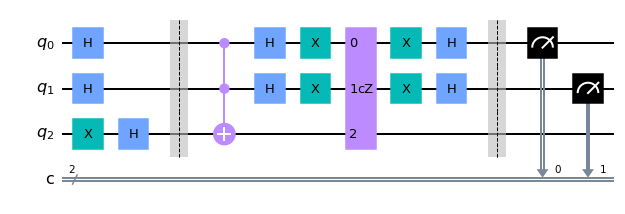

In [10]:
n = 3

circ_grover = grover(n, ones,1)
circ_grover.draw(output='mpl')

In [11]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circ_grover, backend)
counts = job.result().get_counts()
print(counts)

{'11': 1024}


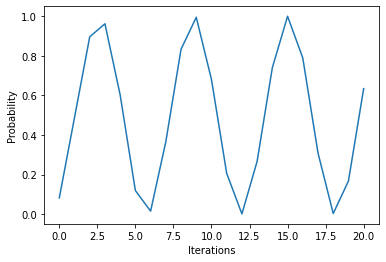

In [12]:
import matplotlib.pyplot as plt

n = 5
max_it = 20
shots = 1000
backend = Aer.get_backend('qasm_simulator')
target = (n-1)*'1'


prob = [0.0 for _ in range(max_it+1)]
for iter in range(max_it+1):
    circ_grover2 = grover(n, ones, iter)
    job = execute(circ_grover2, backend, shots = shots)
    counts = job.result().get_counts()
    if target in counts.keys():
        prob[iter] = counts[target]/shots
    
    else:
        prob[iter] = 0
        
itera = range(max_it+1)
plt.xlabel('Iterations')
plt.ylabel('Probability')
plt.plot(itera,prob)
plt.show()
    